In [ ]:
!pip install pandas
!pip install numpy
!pip install nltk
!pip install textract
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download pt_core_news_sm

# NLP

##### VISÃO GERAL


Uma empresa contratante deseja estabelecer termos de maior relevância em um documento
específico. Neste caso, considere o histórico de exames, consultas e procedimentos realizados
por um paciente. Um sistema deve ser desenvolvido para que o médico possa ter uma visão
geral do histórico do paciente sem a necessidade de analisar documento por documento. Com
base nesta importância, vamos desenvolver uma etapa deste sistema. Tokenizar um texto,
realizar remoção de stopwords, aplicar o processo de lematização e fazer uma análise
quantitativa e visual subjetiva deste.

##### OBJETIVOS


1. Carregar o conjunto de documentos em PDF e armazená-los em alguma estrutura de dados.

In [14]:
from glob import glob

pdf_files = glob('documentos\\*.pdf') # Carregando os arquivos pdf

In [15]:
import textract

read_pdfs = [textract.process(i, encoding='utf-8').decode('utf-8') for i in pdf_files]

In [16]:
import pandas as pd

df = pd.DataFrame(data={"textos": read_pdfs})
df.textos = df.textos.astype('string')

2. Realizar o pré-processamento destes ( tokenização e remoção de stop words, deixar todos os
caracteres minúsculos...).

In [17]:
df.describe()

,textos
count,3
unique,3
top,O câncer de pulmão é a doença maligna mais com...
freq,1


In [18]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
from nltk import word_tokenize
from spacy.lang.pt.stop_words import STOP_WORDS


def remove_stopwords(word):
    stop_words = list(set(stopwords.words('portuguese') + list(STOP_WORDS)))
    return " ".join([i for i in word_tokenize(word) if i not in stop_words])


def standardize_text(df, text_field):   
    df_copy = df.copy()
    df_copy[text_field] = df_copy[text_field].str.lower()
    df_copy[text_field] = df_copy[text_field].apply(lambda x: remove_stopwords(x))
    df_copy[text_field] = df_copy[text_field].map(lambda x: re.sub(r'http\S+', '', x))   
    df_copy[text_field] = df_copy[text_field].str.replace(r"http", "")    
    df_copy[text_field] = df_copy[text_field].map(lambda x: re.sub(r'"@\S+', '', x))   
    df_copy[text_field] = df_copy[text_field].map(lambda x: re.sub(r'\d+', '', x))   
    df_copy[text_field] = df_copy[text_field].str.replace(r"@", "at")    
    df_copy[text_field] = df_copy[text_field].str.strip()
    return df_copy

In [19]:
clean_questions = standardize_text(df, "textos") 
clean_questions

,textos
0,câncer pulmão doença maligna comum mundo ; cas...
1,relativamente poucos dados brasil respeito cân...
2,dados exatos respeito procedimentos cirúrgicos...


In [20]:
from nltk.tokenize import RegexpTokenizer 
tokenizer = RegexpTokenizer(r'\w+') 
clean_questions["tokens"] = clean_questions["textos"].apply(tokenizer.tokenize)
clean_questions.head()

,textos,tokens
0,câncer pulmão doença maligna comum mundo ; cas...,"[câncer, pulmão, doença, maligna, comum, mundo..."
1,relativamente poucos dados brasil respeito cân...,"[relativamente, poucos, dados, brasil, respeit..."
2,dados exatos respeito procedimentos cirúrgicos...,"[dados, exatos, respeito, procedimentos, cirúr..."


In [21]:
#Inspecionando novamente os dados 

all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]] 
VOCAB = sorted(list(set(all_words))) 
print("%s Quantidade total de palavras, com um vocabulario de %s" % (len(all_words), len(VOCAB))) 
print("Tamanho máximo de uma sentença %s" % max(sentence_lengths))

668 Quantidade total de palavras, com um vocabulario de 355
Tamanho máximo de uma sentença 298


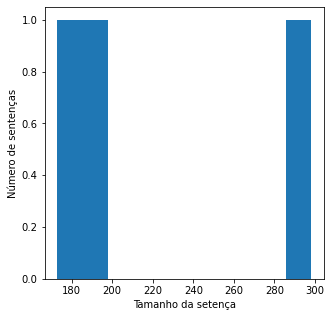

In [26]:
import matplotlib.pyplot as plt


#Distribuição das sentenças por quantidade de palavras 

fig = plt.figure(figsize=(5, 5)) 
plt.xlabel('Tamanho da setença') 
plt.ylabel('Número de sentenças') 
plt.hist(sentence_lengths) 
plt.show()

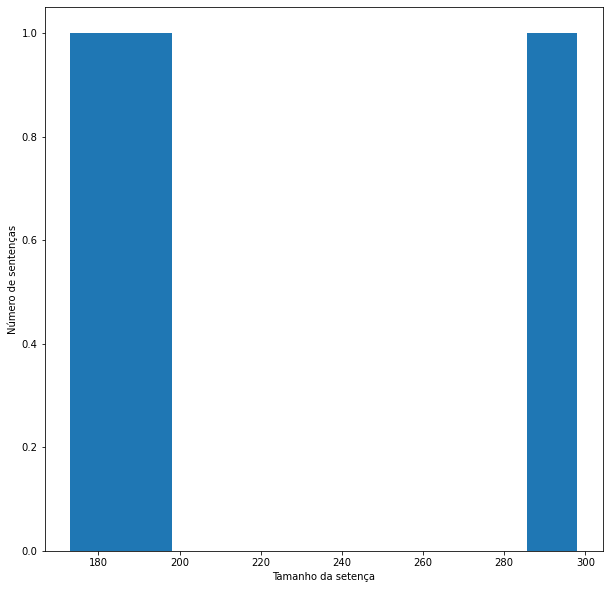

In [13]:
import matplotlib.pyplot as plt


#Distribuição das sentenças por quantidade de palavras 

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Tamanho da setença') 
plt.ylabel('Número de sentenças') 
plt.hist(sentence_lengths) 
plt.show()

3. Lematização com a Lib stanza

4. Implementar para determinar as seguintes informações dos resultados obtidos em 3:

4. <br>  1. Term Frequency (TF):
<br> 𝑇𝐹 = 𝑞𝑡𝑑 𝑑𝑒 𝑜𝑐𝑜𝑟𝑟ê𝑛𝑐𝑖𝑎 𝑑𝑜 𝑡𝑒𝑟𝑚𝑜 𝑒𝑚 𝑢𝑚 𝑡𝑒𝑥𝑡𝑜 / 𝑞𝑢𝑎𝑛𝑡𝑖𝑑𝑎𝑑𝑒 𝑡𝑜𝑡𝑎𝑙 𝑑𝑒 𝑝𝑎𝑙𝑎𝑣𝑟𝑎𝑠 𝑑𝑜 𝑡𝑒𝑥𝑡𝑜


4. <br>  2. Document Frequency (DF):
<br> 𝐷𝐹 = 𝑞𝑡𝑑 𝑑𝑒 𝑜𝑐𝑜𝑟𝑟ê𝑛𝑐𝑖𝑎 𝑑𝑜 𝑡𝑒𝑟𝑚𝑜 𝑒𝑚 𝑢𝑚 𝑐𝑜𝑛𝑗𝑢𝑛𝑡𝑜 𝑑𝑒 𝑑𝑜𝑐𝑢𝑚𝑒𝑛𝑡𝑜𝑠


4. <br>  3. Inverse Document Frequency (IDF):
<br> 𝐼𝐷𝐹 = 𝑙𝑜𝑔(𝑞𝑡𝑑 𝑑𝑒 𝑑𝑜𝑐𝑢𝑚𝑒𝑛𝑡𝑜𝑠 / (𝐷𝐹 + 1))


4. <br>  4. TF-IDF:
<br> 𝑇𝐹 − 𝐼𝐷𝐹 = 𝐼𝐷𝐹 * 𝑇𝐹


4. <br>  5. Lista de strings com proximidade até 2 dos 5 termos de maior TF-IDF. Essas strings
devem ser acompanhadas de seu valor de TF. Exemplo: Suponha que a lista dos 5 termos de maior TF-IDF é [ casa, carro, comida, cachorro, gato]. Carro em um uma frase pode ter pneu e
banco com as palavras mais próximas. Em outra parte do texto, carro pode ter volante e cinto,
como as palavras mais próximas. Neste caso, para o termo carro, as strings [
pneu,banco,volante,cinto] são as que devem ser armazenadas para análise.

5. Gerar um arquivo csv que possui todas as palavras de todos os documentos na primeira coluna,
em que cada linha é um token. Para cada token, informe nas colunas vizinhas as informações
determinadas no objetivo 4.1 até 4.4.

6. Gerar nuvem de palavras para análise visual tal como exemplo abaixo. Cada ponto central será
um dos 5 termos de maior TF-IDF. As conexões são as palavras próximas obtidas em 4.5. O
tamanho do círculo da palavra é baseado no TF dela. O maior círculo que conecta o termo
central será normalizado para palavras de maior TF do conjunto.
![MarineGEO circle logo](https://i.imgur.com/gNv4V7l.png "MarineGEO logo")



**Tópicos de Auxílio**
<br>
<br>
<br>
Informações sobre as métricas utilizadas
<br>
https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089
<br>
<br>
Atividade determinação da nuvem de palavras
<br>
https://www.kaggle.com/code/arthurtok/ghastly-network-and-d3-js-force-directed-graphs/notebook
<br>
http://andrewtrick.com/stormlight_network.html